## Description

    weatherAUS.csv berisi tentang laporan cuaca Australia selama 10 tahun dari 2007 sampai 2017

### Objective

    Melakukan prediksi cuaca untuk variabel 'RainTomorrow', dimana kita akan memprediksi apakah besok akan hujan atau tidak.

    Untuk melakukan prediksi, kita akan menggunakan Algoritma Machine Learning dengan model Logistic Regression dan Support Vector Machine.

    Lakukan prediksi cuaca menggunakan random data

### Problem Statement

    Dataset masih kotor sehingga harus dilakukan pembersihan.

## Working Area

## Import Library

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

%matplotlib inline


import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action="ignore", message="^internal gelsd")

<hr>

## Load Dataset

In [7]:
data = pd.read_csv("weatherAUS.csv")
df = data.copy()
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


<hr>

## Analisis dan visualisasi data

- Membagi data seusai tipe data (kategorik atau numerik)

In [8]:
kategorik = [ i for i in df.columns if df[i].dtype =='O']
numerik = [i for i in df.columns if df[i].dtype !='O']
print('tipe data kategorik:',kategorik, '\n')
print('tipe data numerik:',numerik)

tipe data kategorik: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'] 

tipe data numerik: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


cek missing value pada dataset

In [9]:
df[kategorik].isnull().sum()

Date                0
Location            0
WindGustDir     10326
WindDir9am      10566
WindDir3pm       4228
RainToday        3261
RainTomorrow     3267
dtype: int64

In [10]:
df[numerik].isna().sum()

MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustSpeed    10263
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
dtype: int64

`berdasarkan informasi yang telah didapatkan, diketahui bahwa terdapat banyak missing value baik di kategorik maupun numerik`

- Menghitung jumlah unique data pada tiap kelas/kategori

In [11]:
for i in kategorik:
    print('Jumlah Unique Data',i, ':',df['{}'.format(i)].nunique())

Jumlah Unique Data Date : 3436
Jumlah Unique Data Location : 49
Jumlah Unique Data WindGustDir : 16
Jumlah Unique Data WindDir9am : 16
Jumlah Unique Data WindDir3pm : 16
Jumlah Unique Data RainToday : 2
Jumlah Unique Data RainTomorrow : 2


In [12]:
# Hanya berfokus pada RainTomorrow

df['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

- Kita juga dapat menampilkannya dalam bentuk visual dengan <code>countplot()</code> dari Seaborn.

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

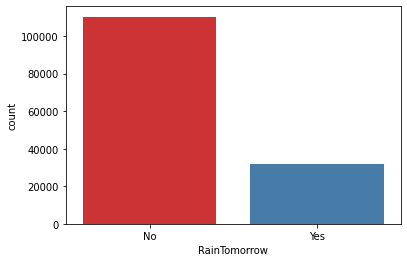

In [13]:
# Menampilkan visualisasi dengan countplot Seaborn
# Fokus untuk menampilkan jumlah data dari RainTomorrow

sns.countplot(x='RainTomorrow', data=df, palette='Set1')

- Untuk kolom numerik, kita dapat melihat sebaran datanya dengan histogram.

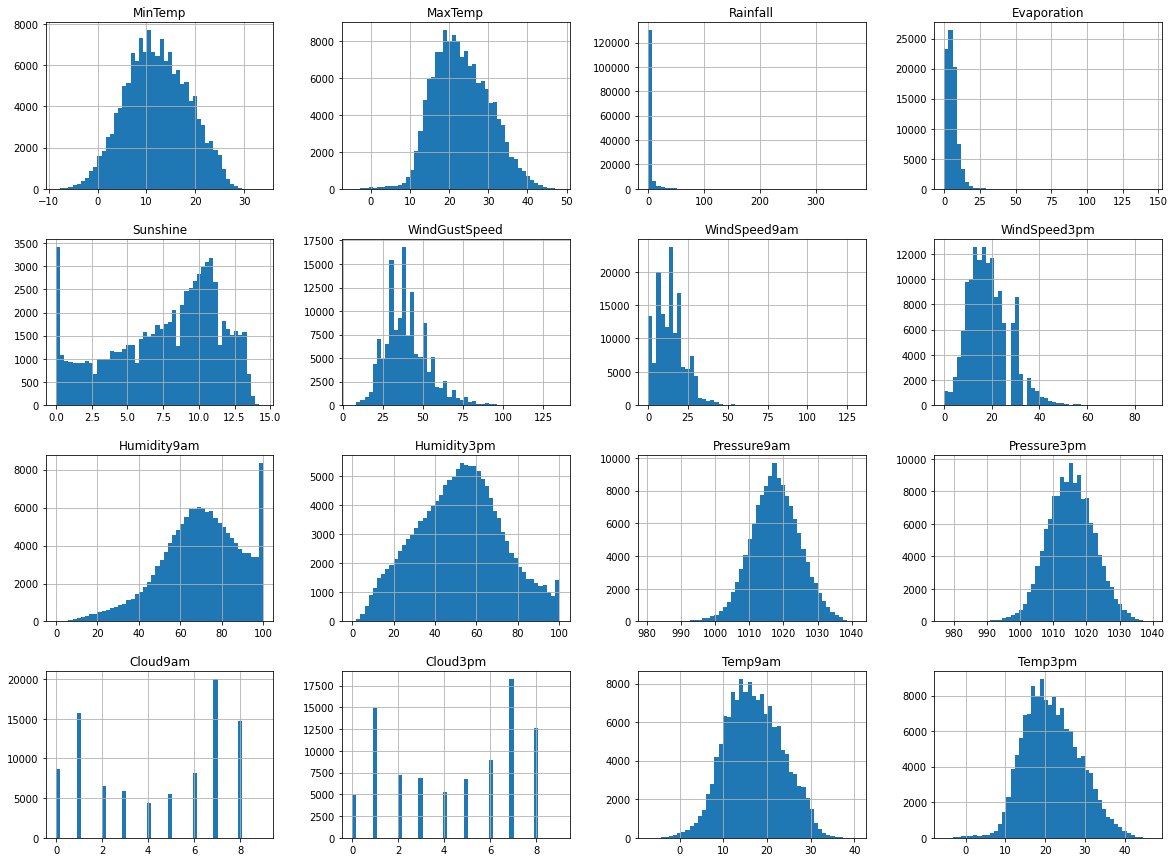

In [14]:
df.hist(bins=50, figsize=(20,15))
plt.show()

`terlihat bahwa beberapa kolom memiliki bentuk distribusi normal dan ada juga yang berbentuk distribusi skewness`

- Melihat korelasi antar fitur dapat ditunjukkan dengan <code>heatmap()</code> dari Seaborn.

<AxesSubplot:>

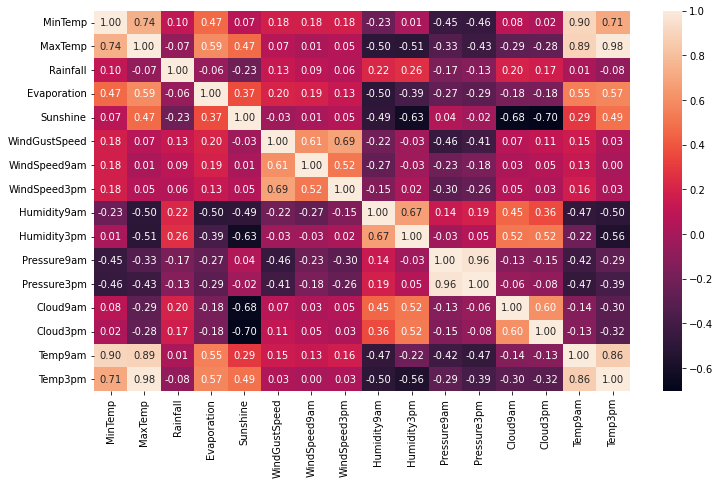

In [15]:
plt.figure(figsize=(12,7))

corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f')

<hr>

## Preprocessing

- cek statistic dasar

In [28]:
median = {
    'Temp3pm'       : [df.median()[15]],
    'Temp9am'       : [df.median()[14]],
    'Cloud3pm'      : [df.median()[13]],
    'Cloud9am'      : [df.median()[12]],
    'Pressure3pm'   : [df.median()[11]],
    'Pressure9am'   : [df.median()[10]],
    'Humidity3pm'   : [df.median()[9]],
    'Humidity9am'   : [df.median()[8]],
    'WindSpeed3pm'  : [df.median()[7]],
    'WindSpeed9am'  : [df.median()[6]],
    'WindGustSpeed' : [df.median()[5]],
    'Sunshine'      : [df.median()[4]],
    'Evaporation'   : [df.median()[3]],
    'Rainfall'      : [df.median()[2]],
    'MaxTemp'       : [df.median()[1]],
    'MinTemp'       : [df.median()[0]]
}
median = pd.DataFrame(median)

median
desc = df.describe()
describe = pd.concat([median, desc], axis=0).rename(index={0:'median'})
describe

,Temp3pm,Temp9am,Cloud3pm,Cloud9am,Pressure3pm,Pressure9am,Humidity3pm,Humidity9am,WindSpeed3pm,WindSpeed9am,WindGustSpeed,Sunshine,Evaporation,Rainfall,MaxTemp,MinTemp
median,21.10000,16.700000,5.000000,5.000000,1015.200000,1017.60000,52.000000,70.000000,19.000000,13.000000,39.000000,8.400000,4.800000,0.000000,22.600000,12.000000
count,141851.00000,143693.000000,86102.000000,89572.000000,130432.000000,130395.00000,140953.000000,142806.000000,142398.000000,143693.000000,135197.000000,75625.000000,82670.000000,142199.000000,144199.000000,143975.000000
mean,21.68339,16.990631,4.509930,4.447461,1015.255889,1017.64994,51.539116,68.880831,18.662657,14.043426,40.035230,7.611178,5.468232,2.360918,23.221348,12.194034
std,6.93665,6.488753,2.720357,2.887159,7.037414,7.10653,20.795902,19.029164,8.809800,8.915375,13.607062,3.785483,4.193704,8.478060,7.119049,6.398495
min,-5.40000,-7.200000,0.000000,0.000000,977.100000,980.50000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,-4.800000,-8.500000
25%,16.60000,12.300000,2.000000,1.000000,1010.400000,1012.90000,37.000000,57.000000,13.000000,7.000000,31.000000,4.800000,2.600000,0.000000,17.900000,7.600000
50%,21.10000,16.700000,5.000000,5.000000,1015.200000,1017.60000,52.000000,70.000000,19.000000,13.000000,39.000000,8.400000,4.800000,0.000000,22.600000,12.000000
75%,26.40000,21.600000,7.000000,7.000000,1020.000000,1022.40000,66.000000,83.000000,24.000000,19.000000,48.000000,10.600000,7.400000,0.800000,28.200000,16.900000
max,46.70000,40.200000,9.000000,9.000000,1039.600000,1041.00000,100.000000,100.000000,87.000000,130.000000,135.000000,14.500000,145.000000,371.000000,48.100000,33.900000


- Mari kita lihat <code>info()</code> dari dataframe <code>df kategorik</code>.

In [12]:
df[kategorik].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Date          145460 non-null  object
 1   Location      145460 non-null  object
 2   WindGustDir   135134 non-null  object
 3   WindDir9am    134894 non-null  object
 4   WindDir3pm    141232 non-null  object
 5   RainToday     142199 non-null  object
 6   RainTomorrow  142193 non-null  object
dtypes: object(7)
memory usage: 7.8+ MB


In [13]:
df[kategorik].isnull().sum()

Date                0
Location            0
WindGustDir     10326
WindDir9am      10566
WindDir3pm       4228
RainToday        3261
RainTomorrow     3267
dtype: int64

`Dari hasil di atas, terlihat bahwa ada banyak `<i>missing values</i>` namun tipe datanya sudah sesuai.`

- Menghapus missing value dari kolom RainTomorrow

In [14]:
print('Sebelum :',df.shape)
df.dropna(subset=['RainTomorrow'],inplace = True)
df = df.reset_index(drop=True)
print('Setelah :', df.shape)

Sebelum : (145460, 23)
Setelah : (142193, 23)


- Mengubah format kolom Date dan membagi sesuai tahun, bulan, dan hari

In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df.drop('Date',axis = 1,inplace = True)

In [16]:
df[['year', 'month','day']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   year    142193 non-null  int64
 1   month   142193 non-null  int64
 2   day     142193 non-null  int64
dtypes: int64(3)
memory usage: 3.3 MB


In [17]:
df[['year', 'month','day']] = df[['year', 'month','day']].astype('string')
print(df.year.dtypes)

string


`Kolom Date tipe datanya akan diubah menjadi string, agar memudahkan untuk memodifikasi tipe data integer lainnya. Ini hanya sementara, berikutnya akan dikembalikan menjadi tipe integer`

Mari kita lihat <code>info()</code> dari dataframe <code>df numerik</code>.

In [18]:
df[numerik].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        141556 non-null  float64
 1   MaxTemp        141871 non-null  float64
 2   Rainfall       140787 non-null  float64
 3   Evaporation    81350 non-null   float64
 4   Sunshine       74377 non-null   float64
 5   WindGustSpeed  132923 non-null  float64
 6   WindSpeed9am   140845 non-null  float64
 7   WindSpeed3pm   139563 non-null  float64
 8   Humidity9am    140419 non-null  float64
 9   Humidity3pm    138583 non-null  float64
 10  Pressure9am    128179 non-null  float64
 11  Pressure3pm    128212 non-null  float64
 12  Cloud9am       88536 non-null   float64
 13  Cloud3pm       85099 non-null   float64
 14  Temp9am        141289 non-null  float64
 15  Temp3pm        139467 non-null  float64
dtypes: float64(16)
memory usage: 17.4 MB


In [19]:
df[numerik].isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
dtype: int64

`Dari hasil di atas, terlihat bahwa ada banyak `<i>missing values</i>` namun tipe datanya sudah sesuai.`

- Membuat fungsi def untuk melihat outlier pada setiap kolom numerik

In [20]:
def print_outlier(df, col):
    plt.figure(figsize = (10, 5))
    sns.boxplot(df[col])
    plt.annotate('Outlier', (df[col].describe()['max'],0.1), xytext = (df[col].describe()['max'],0.3),
                arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
    plt.annotate('Outlier', (df[col].describe()['min'],0.1), xytext = (df[col].describe()['min'],0.3),
                arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
    IQR = df[col].describe()['75%'] - df[col].describe()['25%']

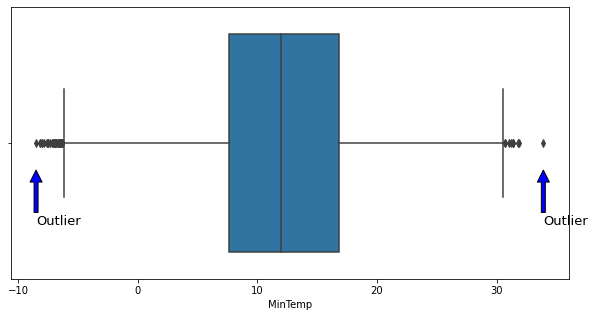

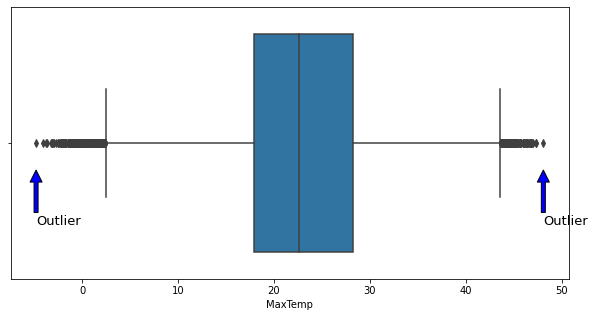

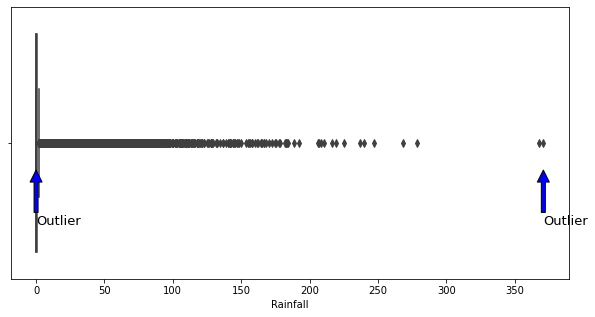

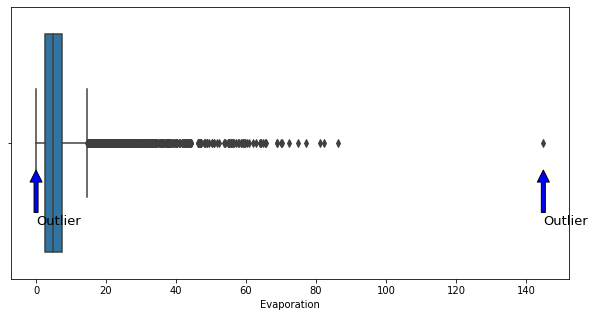

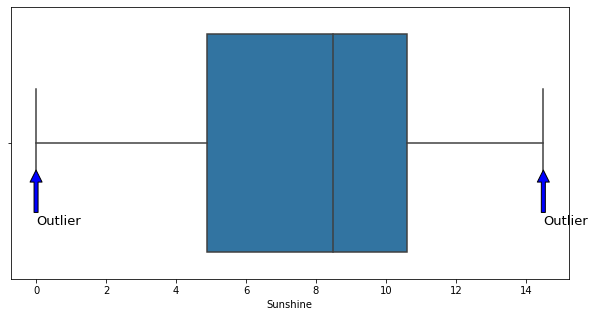

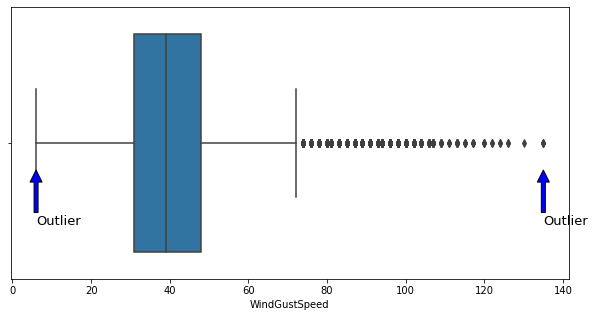

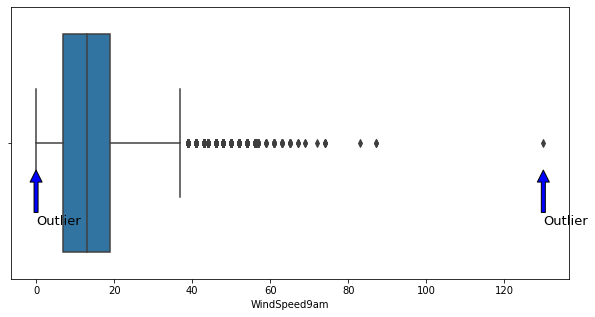

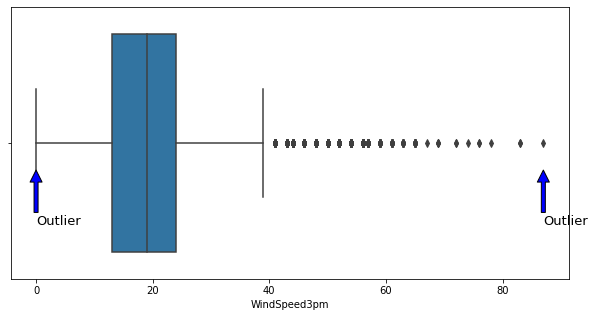

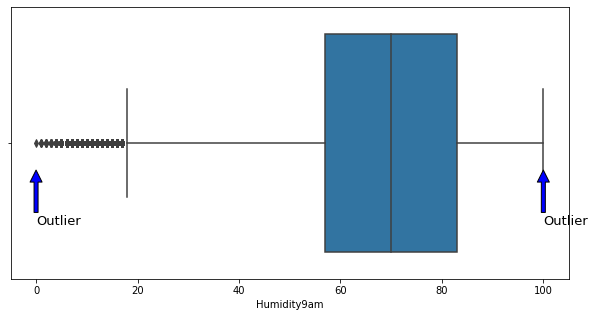

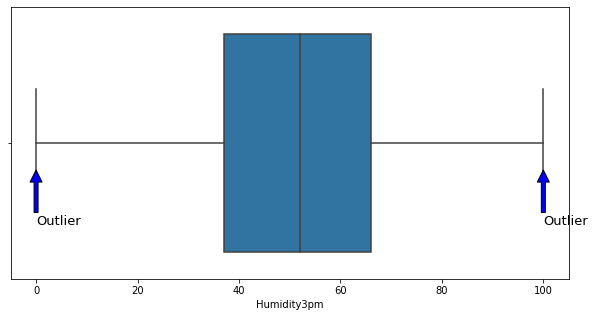

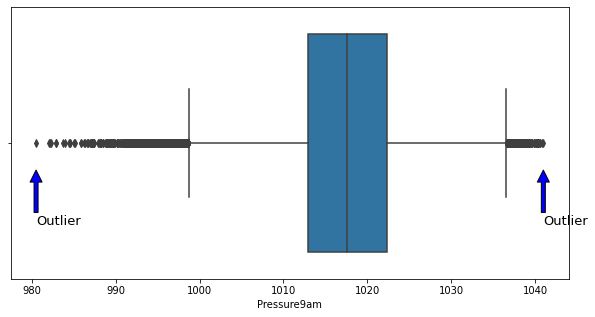

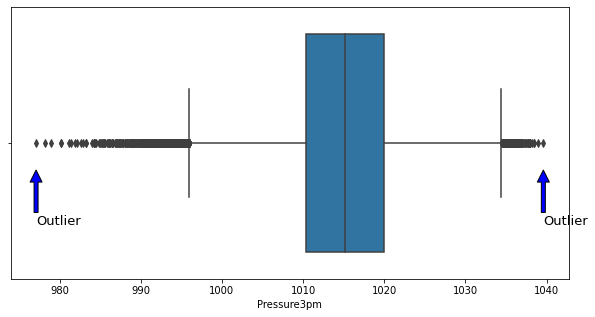

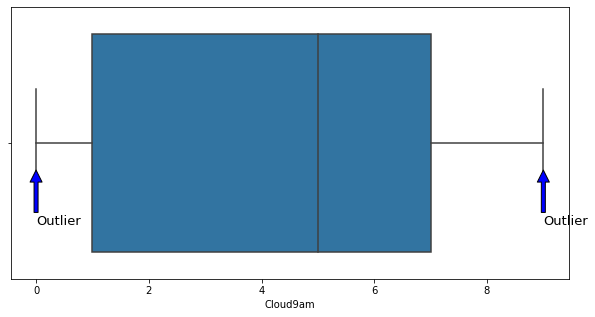

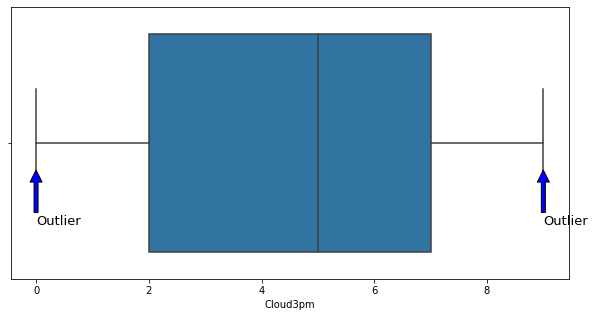

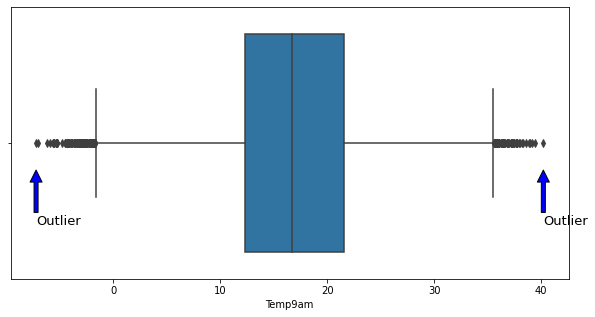

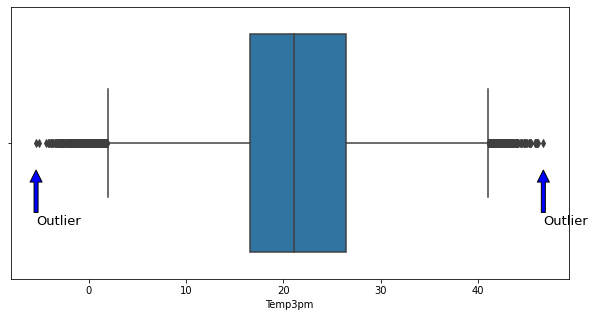

In [21]:
for i in numerik:
    print_outlier(df, '{}'.format(i))

`Terlihat banyak outlier pada setiap kolom numerik`

- Membuat fungsi def yang akan digunakan untuk mengeluarkan outlier

In [22]:
# membuat fungsi untuk mengecek nilai yang menjadi outlier

def cek_outlier(df, x):
    Q1 = df[x].describe()['25%']
    Q3 = df[x].describe()['75%']
    IQR = Q3-Q1
    return df[(df[x] < Q1-1.5*IQR) | (df[x] > Q3+1.5*IQR)]



# membuat fungsi untuk menghapus nilai yang outlier

def hapus_outlier(df, x):
    
    q1 = df[x].quantile(0.25) # 25% percentile
    q3 = df[x].quantile(0.75) # 75% percentile
    
    iqr = q3-q1
    bawah  = q1-1.5*iqr
    atas = q3+1.5*iqr
    
    df.drop(df[ (df[x] > atas) | (df[x] < bawah) ].index, inplace=True)



In [23]:
for i in numerik:
    hapus_outlier(df,i)

- Mengembalikan tipe data kolom Date menjadi integer

In [24]:
df[['year', 'month','day']] = df[['year', 'month','day']].astype('int')
print(df.year.dtypes)

int32


<hr>

### Train test split

- Mendefinisikan fitur dan target. 

In [25]:
X = df.drop('RainTomorrow', axis=1)       # fitur
y = df['RainTomorrow']                    # label

- Selanjutnya kita lakukan <code>train_test_split()</code>.

In [26]:
from sklearn.model_selection import train_test_split

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (85016, 24) (85016,)
Test set: (21255, 24) (21255,)


- <i>handle missing value<i> pada kolom numerik dengan menggunakan median dari setiap kolom 

In [27]:
for df in [X_train, X_test]:
    for col in numerik:
        col_median=X_train[col].median()
        df[col].fillna(col_median, inplace=True)

- cek ulang <i>missing value<i> pada kolom numerik

In [28]:
X_test[numerik].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [29]:
X_train[numerik].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

`terlihat bahwa sudah tidak ada missing value pada kolom numerik`

- <i>handle missing value<i> pada kolom kategorik dengan menggunakan modus dari setiap kolom 

In [30]:
for df1 in [X_train, X_test]:
    df1['WindGustDir'].fillna(X_train['WindGustDir'].mode()[0], inplace=True)
    df1['WindDir9am'].fillna(X_train['WindDir9am'].mode()[0], inplace=True)
    df1['WindDir3pm'].fillna(X_train['WindDir3pm'].mode()[0], inplace=True)
    df1['RainToday'].fillna(X_train['RainToday'].mode()[0], inplace=True)

- Memisahkan kolom kategorik pada X_train

In [31]:
categorical = [i for i in X_train.columns if X_train[i].dtype == 'O']

categorical.remove('Location') #location dihapus karena tidak memiliki missing value

`karena fitur dan target telah dipisah, yang mana RainTomorrow telah terpisah dengan kolom fitur lainnya (menjadi target), sehingga memisahkan ulang antara kolom numerik dan kategorik pada X_train.`

- cek missing value pada kolom numerik

In [32]:
X_train[categorical].isnull().sum()

WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64

In [33]:
X_test[categorical].isnull().sum()

WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64

`terlihat bahwa kolom kategorik sudah tidak memiliki missing value`

- membuat fungsi def untuk proses encoding

In [34]:
def label(col):
    label = preprocessing.LabelEncoder()
 
    X_train[col] = label.fit_transform(X_train[col])
    X_test[col]  = label.transform(X_test[col])

In [35]:
def hot(col):
    hot = OneHotEncoder(sparse=False)
    
    train  =  hot.fit_transform(X_train[[col]])
    test   =  hot.fit_transform(X_test[[col]])
    
    train_df = pd.DataFrame(train)
    test_df = pd.DataFrame(test)
    
    header = X_train[col].sort_values().unique()
    
    train_df.columns = col+'_'+header
    test_df.columns  = col+'_'+header
    
    
    return train_df, test_df

- lakukan proses encoding pada kolom kategorik

In [36]:
train_location, test_location = hot('Location')
train_WindGustDir, test_WindGustDir = hot('WindGustDir')
train_WindDir9am, test_WindDir9am = hot('WindDir9am')
train_WindDir3pm, test_WindDir3pm = hot('WindDir3pm')
train_RainToday, test_RainToday = hot('RainToday')

- menggabungkan seluruh data (kolom numerik dan kolom kategorik yang telah di encoding)

In [37]:
X_train = pd.concat([X_train[numerik].reset_index(drop=True), train_location,train_WindGustDir,train_WindDir9am, train_WindDir3pm, train_RainToday], axis= 1)

X_test  = pd.concat([X_test[numerik].reset_index(drop=True), test_location,test_WindGustDir,test_WindDir9am, test_WindDir3pm, test_RainToday], axis= 1)

<hr>

### Data Normalization

- melakukan normalisasi agar semua data skalanya seimbang

In [38]:
cols = X_train.columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

<hr>

### Model Training

- membuat model untuk fitting

In [39]:
def fitting(model):
    
    model.fit(X_train, y_train)
    score = model.score(X_test,y_test)
    
    return score

#### `Logistik Regression`

- melakukan training data menggunakan model logistic regression

In [54]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
log_score = fitting(logreg)

print('score Data Test   = %0.4f' % log_score)
print('Score Data Train  = {:.4f}'.format(logreg.score(X_train, y_train)))

score Data Test   = 0.8744
Score Data Train  = 0.8750


`berdasarkan dari score data train dan test, terlihat bahwa model tidak overfitting dimana hasil skor score Data Train (0.8750) > score Data Test (0.8744)`

- tes model

In [41]:
y_pred = logreg.predict(X_test)

- Evaluasi hasil model Logistic Regression dengan <code>accuracy_score()</code> untuk <i>train set</i> dan <i>test set</i>-nya.

In [42]:
print('Train set Accuracy: %.4f' % accuracy_score(y_train, logreg.predict(X_train)))
print('Test set Accuracy: %.4f' % accuracy_score(y_test, y_pred))

Train set Accuracy: 0.8750
Test set Accuracy: 0.8744


`accurasi dari data train dan test juga sama`

- Kita juga dapat menampilkan <i>classification_report<i>-nya.

In [43]:
print('Classification report : ')
print(classification_report(y_test, y_pred, zero_division=1))

Classification report : 
              precision    recall  f1-score   support

          No       0.89      0.97      0.93     17927
         Yes       0.70      0.34      0.46      3328

    accuracy                           0.87     21255
   macro avg       0.80      0.66      0.70     21255
weighted avg       0.86      0.87      0.86     21255



Seperti yang dapat kita lihat, hasil akurasi untuk <i>data test</i> sekitar __0.8734__, sementara untuk <i>data train</i> sekitar __0.8736__.

`Model Logistik Regression ini mampu memprediksi cuaca dengan akurasi sekitar 87.34%`

<hr>

### K-Fold Cross Validation

In [44]:
tot_data_x = pd.concat([X_train, X_test]).reset_index(drop=True)
tot_data_y = pd.concat([y_train, y_test]).reset_index(drop=True)
tot_data   = pd.concat([tot_data_x, tot_data_y], axis= 1)

In [45]:
kf = KFold(n_splits=10, random_state=42, shuffle=True) 

# Training dan testing model
model_logreg = LogisticRegression(solver='liblinear', class_weight='balanced').fit(tot_data_x, tot_data_y)

# Evaluasi model dengan cross_val_score dengan scoring 'accuracy'
scores = cross_val_score(model_logreg, tot_data_x, tot_data_y, scoring='accuracy', cv=kf, n_jobs=-1)
print('Accuracy score: %.4f' % (np.mean(scores)))

Accuracy score: 0.7768


`Accuracy skor dengan menggunakan K Fold lebih rendah dibanding dengan train test split yaitu hanya 77.36%`

<hr>

#### `Support Vector Machine`

- Training Model dengan menggunakan SVC

`disclaimer : beberapa fitur akan di drop guna mempersingkat waktu`

- Membuat X_train dan X_test baru

In [46]:
X_train2 = pd.concat([X_train[numerik].reset_index(drop=True), train_location,train_RainToday], axis= 1)
X_test2  = pd.concat([X_test[numerik].reset_index(drop=True), test_location, test_RainToday], axis= 1)

- Melatih model SVM

In [47]:
model = SVC(kernel='linear').fit(X_train2, y_train)

- Menguji model / memprediksi dengan X_test

In [48]:
y_pred = model.predict(X_test2)

- Melihat score data

In [56]:
print('Score Data Train = {:.4f}'.format(model.score(X_train2, y_train)))
print('Score Data Test  = {:.4f}'.format(model.score(X_test2, y_test)))

Score Data Train = 0.8714
Score Data Test  = 0.8709


`berdasarkan dari score data train dan test, terlihat bahwa model tidak overfitting dimana hasil skor score Data Train (0.8714) > score Data Test (0.8709)`

- Evaluasi hasil model Support Vector Machine dengan <code>accuracy_score()</code> untuk <i>train set</i> dan <i>test set</i>-nya.

In [51]:
print('Train set Accuracy: %.4f' % accuracy_score(y_train, model.predict(X_train2)))
print('Test set Accuracy: %.4f' % accuracy_score(y_test, y_pred))

Train set Accuracy: 0.8714
Test set Accuracy: 0.8709


Seperti yang dapat kita lihat, hasil akurasi untuk <i>data test</i> sekitar __0.8709__, sementara untuk <i>data train</i> sekitar __0.8714__.

`Model Support Vector Machine ini mampu memprediksi cuaca dengan akurasi sekitar 87.09%`

<hr>

## Kesimpulan

`Hasil accuracy tes dari setiap test :`

- `Akurasi Model Logistic Regression: 87.34%`
- `Akurasi Model SVM: 87.09%`

`Berdasarkan accuracy test dari kedua model, diketahui bahwa Model Logistic Regression lebih baik daripada Model SVM`



<hr>

## Model Inference

- Menguji model dengan membuat 10 random data secara acak dari gabungan X_train dan X_test

In [95]:
coba = pd.concat([X_test.sample(10000), X_train.sample(10000)])
coba2 = pd.concat([X_test2.sample(10000), X_train2.sample(10000)])

In [99]:
dummy = coba.sample(10)
dummy2 = coba2.sample(10)

- Uji Data dengan model

    1. Logistic Regression

In [97]:
dummy_loreg = logreg.predict(dummy)
print(dummy_loreg)

['No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No']


    2. SVM

In [101]:
dummy_svm = model.predict(dummy2)
print(dummy_svm)

['No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No']
